In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', None)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report


from tensorflow.keras.preprocessing.text import Tokenizer


import joblib

import gensim


from nltk.tokenize import word_tokenize
from hausastemmer import HausaStemmer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


2023-11-21 07:07:50.593544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## import the data

In [3]:
df1 = pd.read_table('ha_train.tsv')
df2 = pd.read_table('ha_dev_gold_label.tsv')
df = pd.concat([df1, df2],ignore_index=True)
df.head()

,ID,tweet,label
0,ha_train_00001,@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣,negative
1,ha_train_00002,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ne shugaban sojoji.... Gaskiya Buhari kaci Amanan mu da kasa wannan mutum ah wajen nan,negative
2,ha_train_00003,@user Sai haquri fa yan madrid daman kunce champion din ya muku yawa😂,negative
3,ha_train_00004,@user Hmmm yanzu kai kasan girman allah daxakace mukuma ga Allah kune kukabarshi kuna karyata ayoyinsa kace allah baya karbar adduar talakan nigeria 🇳🇬 bayan kunzalunceshi kuma allah ya karbar adduar wanda aka zalunta cikin sauri amma kace wai Allah baya karbar addua talakawa,negative
4,ha_train_00005,@user @user Wai gwamno nin Nigeria suna afa kwayoyi ko 😂,negative


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16849 entries, 0 to 16848
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      16849 non-null  object
 1   tweet   16849 non-null  object
 2   label   16849 non-null  object
dtypes: object(3)
memory usage: 395.0+ KB


The column

In [5]:
df['label'].value_counts()

neutral     5808
positive    5574
negative    5467
Name: label, dtype: int64

In [6]:
df['label'].isnull().sum()

0

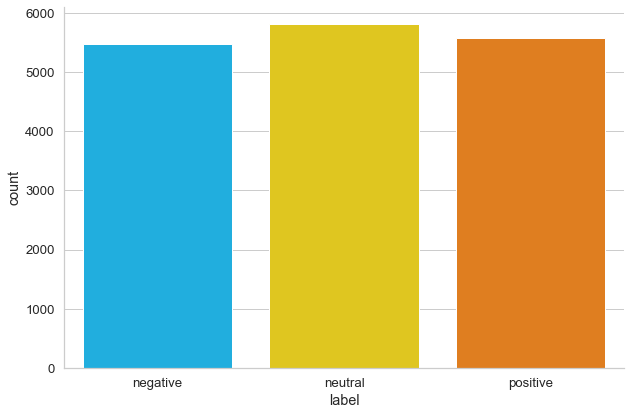

In [7]:
ax = sns.catplot(x="label", data=df, kind="count", height=6, aspect=1.5)
plt.show();

In [8]:
class_mapping = {'negative':0,'neutral':1,'positive':2}
df['label'] = df['label'].map(class_mapping)
class_names =['negative','neutal','positive']

    The tweets column


To analyze the text variable we create a class **TextCounts**. In this class we compute some basic statistics on the text variable. This class can be used later in a Pipeline, as well.

* **count_words** : number of words in the tweet

* **count_hashtags** : number of tag words, preceded by a #
* **count_capital_words** : number of uppercase words, could be used to *"shout"* and express (negative) emotions
* **count_excl_quest_marks** : number of question or exclamation marks
* **count_urls** : number of links in the tweet, preceded by http(s)
* **count_emojis** : number of emoji, which might be a good indication of the sentiment

In [9]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r':[a-z_&]+:', x))
        
        df = pd.DataFrame({'count_words': count_words
                        
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df

In [10]:
tc = TextCounts()
df_eda = tc.fit_transform(df.tweet)

df_eda['label'] = df['label']

Descriptive stats for count_words
---------------------------------
        count       mean        std  min  25%   50%   75%   max
label                                                          
0      5467.0  16.351747  11.482647  4.0  8.0  13.0  21.0  60.0
1      5808.0  11.175103   7.600890  4.0  6.0   9.0  13.0  56.0
2      5574.0  14.177610   9.904099  3.0  7.0  11.0  18.0  61.0


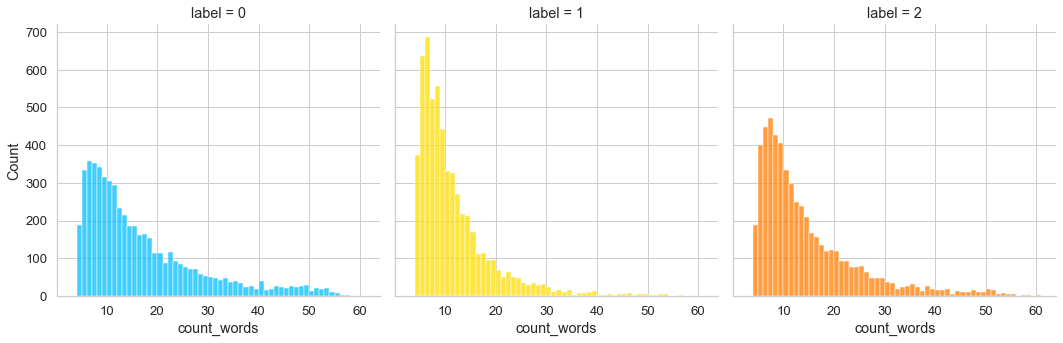

In [11]:
def show_hist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', height=5, hue='label')
    g = g.map(sns.histplot, col, kde=False, bins=bins)
    plt.show()
   
show_hist(df_eda, 'count_words')

Descriptive stats for count_hashtags
------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.026340  0.215655  0.0  0.0  0.0  0.0   6.0
1      5808.0  0.032886  0.332686  0.0  0.0  0.0  0.0  14.0
2      5574.0  0.034266  0.232962  0.0  0.0  0.0  0.0   4.0


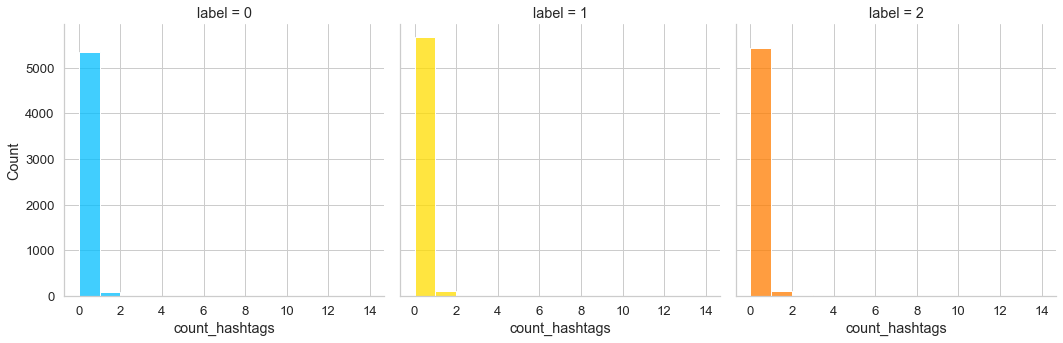

In [14]:
show_hist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.168831  1.122987  0.0  0.0  0.0  0.0  31.0
1      5808.0  0.146006  1.027786  0.0  0.0  0.0  0.0  41.0
2      5574.0  0.188913  1.316439  0.0  0.0  0.0  0.0  51.0


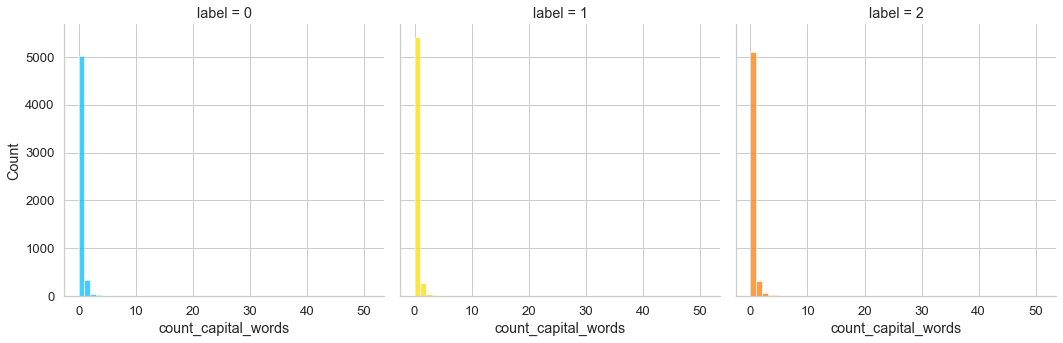

In [15]:
show_hist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5467.0  0.213097  0.707591  0.0  0.0  0.0  0.0  11.0
1      5808.0  0.192665  0.610652  0.0  0.0  0.0  0.0  12.0
2      5574.0  0.108001  0.549535  0.0  0.0  0.0  0.0  19.0


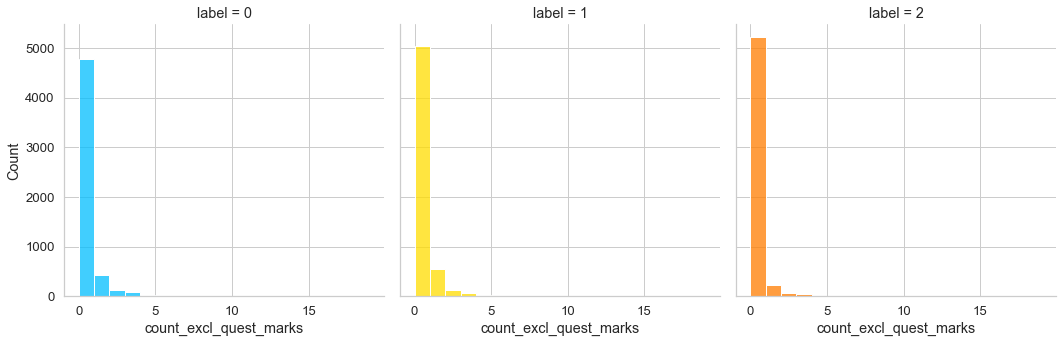

In [16]:
show_hist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5467.0  0.027986  0.173594  0.0  0.0  0.0  0.0  2.0
1      5808.0  0.040461  0.213014  0.0  0.0  0.0  0.0  3.0
2      5574.0  0.027987  0.170303  0.0  0.0  0.0  0.0  2.0


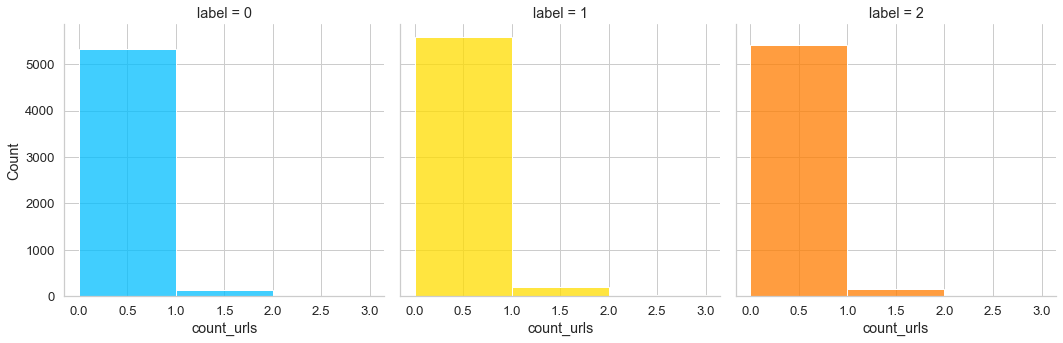

In [17]:
show_hist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
        count      mean       std  min  25%  50%  75%    max
label                                                       
0      5467.0  2.198646  2.875457  0.0  1.0  2.0  3.0  126.0
1      5808.0  1.966942  1.691746  0.0  1.0  1.0  3.0   32.0
2      5574.0  1.994080  2.235177  0.0  1.0  1.0  3.0   88.0


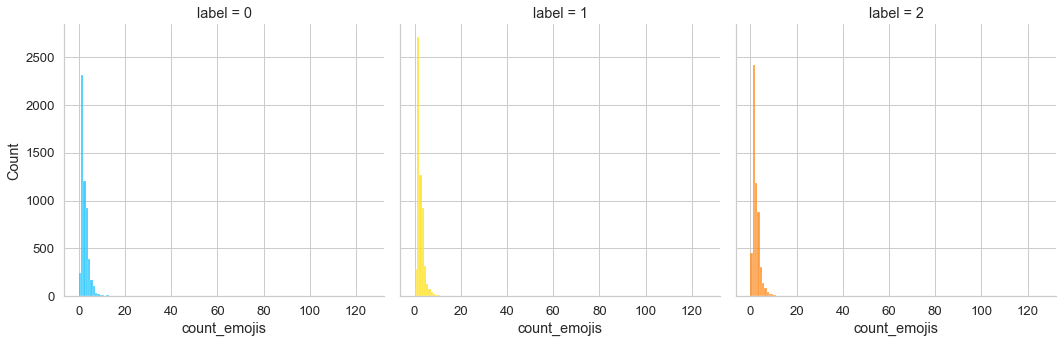

In [18]:
show_hist(df_eda, 'count_emojis')

Code-mixed handling

This is handle in the other notebook separately


**CONCLUSIONS: **
* **The number of words** used in the tweets is rater low. Minimun number of words is 3.
* Most of the tweets do not contain **hash tags**. So probably this variable will not be retained during model training.
* Most of the tweets do not contain **capitalized words** and we do not see a difference in distribution between the sentiments.
* The positive tweets seem to be using a bit more **exclamation or question marks**.
* Only few tweets do not contain a **URL**. 


# Text Cleaning
Before we start using the tweets' text we clean it. We'll do the this in the class CleanText:
remove the **hash tag sign**
set all words to **lowercase**
remove all **punctuations**, including the question and exclamation marks
remove the **urls** as they do not contain useful information and we did not notice a distinction in the number of urls used between the sentiment classes.
remove **digits**
remove **stopwords**
apply the **Our Hausastemmer** to keep the stem of the words

In [32]:
class CleanText(BaseEstimator, TransformerMixin):
   
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def remove_stopwords(self, input_text):
            
        # This stop are a gotting from the different online repositories as there is no standardation on the Huasa stopword.
        stopwords_list = ['a', 'amma', 'ba', 'ban', 'ce', 'cikin', 'da', 'don', 'ga', 'in', 'ina', 'ita', 'ji', 'ka', 'ko', 'kuma', 'lokacin', 'ma', 'mai', 'na', 'ne', 'ni', 'sai', 'shi', 'su', 'suka', 'sun', 'ta', 'tafi', 'take', 'tana', 'wani', 'wannan', 'wata', 'ya', 'yake', 'yana', 'yi', 'za']
        
        # This stop are a gotting from the different online repositories as there is no standardation on the Huasa stopword.
        words = input_text.split()
        clean_words = [w for w in words if not w in  stopwords_list]
        return " ".join(clean_words) 
    
    # filterout the words that are single
    def single_word_fillter(self, input_text):
        
        words = input_text.split()
        filtered_words = [word for word in words if len(word)> 1]
        return " ".join(filtered_words) 
    
    def stemming(self, input_text):
        hausastemmer = HausaStemmer()
        words = input_text.split() 
        stemmed_words = [ hausastemmer.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def to_lower(self, input_text):
        return input_text.lower()

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.single_word_fillter).apply(self.stemming)
        return clean_X
    


In [ ]:
#To show how the cleaned text variable will look like, here's a sample.
ct = CleanText()
cleaned_tweets = ct.fit_transform(df.tweet)
df['cleaned_tweet'] = cleaned_tweets  # Add the cleaned tweets as a new column
print(df.sample(1))
df.to_csv('clean_hausa_tweet.csv', index= False)

### checking and empty tweet after cleaning

In [48]:
empty_clean = sr_clean == ''
print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))
sr_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


Now that we have the cleaned text of the tweets, we can have a look at what are the most frequent words. Below we'll show the top 20 words. 

**CONCLUSION: **Not surprisingly the most frequent word is Allah.

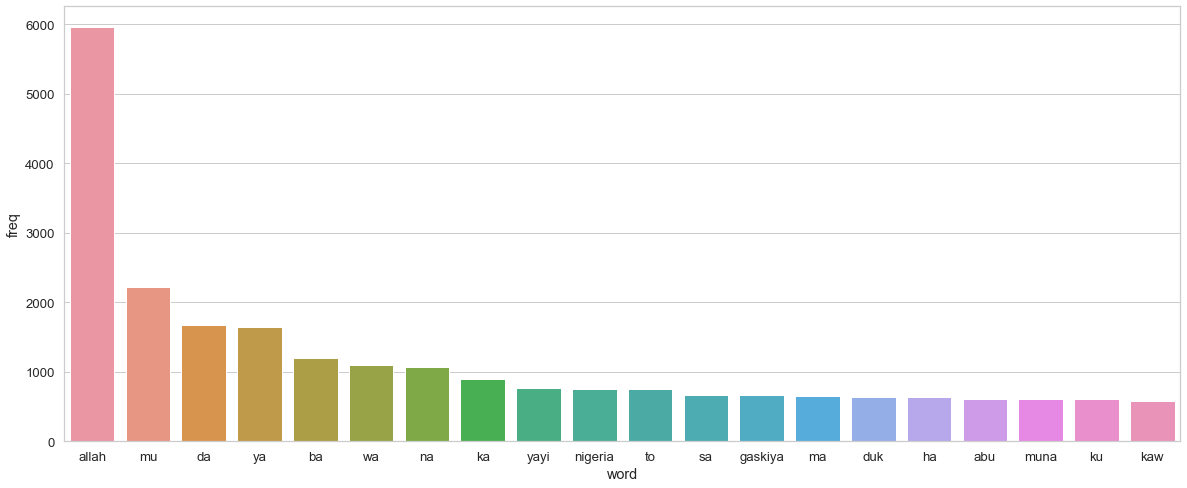

In [49]:
cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names_out(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(20, 8))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df)
plt.show();

## <a id="5">Splitting the Data</a>

In [50]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [80]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 32  # Size of the batches used in the mini-batch gradient descent

GLOVE_DIM = 100  # Number of dimensions of the GloVe word embeddings
MAX_LEN = 120  # Maximum number of words in a sequence
LEARNING_RATE = 1e-5
DROPOUT_RATE=0.3


In [52]:
df.head()

,ID,tweet,label,token_length,cleaned_tweet
0,ha_train_00001,@user Da kudin da Arewa babu wani abin azo agani da yayi wa alummah allah ya isa yacucemu wlh yarikitamana kasa yarikitamana kasuwanci harkar ilimi harkar lfy hanyoyi babu lantarki dasuransu komai yalalace ga cinhanci da rashawa a fili ko ina a Nigeria jamiyaryar su tabataman mlm 😭🗣,0,49,kudi arewa babu abi azo aga yayi wa alummah allah i yacucemu wlh yarikitam ka yarikitam kasuwan hark ilimi hark lfy hany babu lantar dasura kom yalalace cinhan rash fili nigeria jamiyary tabatama mlm 😭🗣
1,ha_train_00002,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ne shugaban sojoji.... Gaskiya Buhari kaci Amanan mu da kasa wannan mutum ah wajen nan,0,27,kaga adu banda💔😭 w ha shugaba sojoji gaskiya buhari ka amana mu ka mutum ah waje na
2,ha_train_00003,@user Sai haquri fa yan madrid daman kunce champion din ya muku yawa😂,0,14,haquri ya madrid dama kunce champio di mu yawa😂
3,ha_train_00004,@user Hmmm yanzu kai kasan girman allah daxakace mukuma ga Allah kune kukabarshi kuna karyata ayoyinsa kace allah baya karbar adduar talakan nigeria 🇳🇬 bayan kunzalunceshi kuma allah ya karbar adduar wanda aka zalunta cikin sauri amma kace wai Allah baya karbar addua talakawa,0,45,hmmm yanzu k kasa girma allah daxakace mukuma allah kune kukabar kuna karyata ayoyi kace allah baya karb addu talaka nigeria 🇳🇬 baya kunzalunce allah karb addu wa a zalu sauri kace w allah baya karb addua talak
4,ha_train_00005,@user @user Wai gwamno nin Nigeria suna afa kwayoyi ko 😂,0,13,w gwamno ni nigeria suna a kway


In [53]:
df.columns

Index(['ID', 'tweet', 'label', 'token_length', 'cleaned_tweet'], dtype='object')

In [54]:
print(df['cleaned_tweet'].apply(type).value_counts())

<class 'str'>    16849
Name: cleaned_tweet, dtype: int64


In [35]:
df = df[df['cleaned_tweet'].apply(lambda x: isinstance(x, str))]

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13479
# Test data samples: 3370


In [56]:
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

# Tokenize the text data
tk = Tokenizer(num_words=NB_WORDS, split=" ")
tk.fit_on_texts(X_train)

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [13]:
#seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
#seq_lengths.describe()

In [57]:
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

In [58]:
X_train_seq_trunc[20]  # Example of padded sequence

array([   1,   45,   10,  124,  283,    1,   45,  198,   67,   69,    1,
          2,  430,  669, 7535, 7536, 1058,  685, 1194,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [59]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [60]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (1348, 120)


## Importing Pretrain GloVe

In [61]:
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('glove/glove.6B.100d.txt')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [63]:
Hausa_tweet = ['baya', 'zazzau', 'di', 'kamata',  'fara' ,'nun' ,'seda' ,'ku','is', 'beautiful','city'
                 'gama', 'yad', 'duniya', 'sanna', 'za', 'dawo' , 'nuna' ,'m' ,'zaria']
for w in Hausa_tweet:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word baya in the dictionary
Found the word zazzau in the dictionary
Found the word di in the dictionary
Found the word kamata in the dictionary
Found the word fara in the dictionary
Found the word nun in the dictionary
Found the word seda in the dictionary
Found the word ku in the dictionary
Found the word is in the dictionary
Found the word beautiful in the dictionary
Found the word yad in the dictionary
Found the word duniya in the dictionary
Found the word sanna in the dictionary
Found the word za in the dictionary
Found the word nuna in the dictionary
Found the word m in the dictionary
Found the word zaria in the dictionary


To feed this into an Embedding layer, we need to build a matrix containing the words in the tweets and their representative word embedding. So this matrix will be of shape (NB_WORDS, GLOVE_DIM)

In [64]:
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

With the *set_weights* method we load the pre-trained embeddings in the Embedding layer (here layer 0). By setting the *trainable* attribute to False, we make sure not to change the pre-trained embeddings.

In [67]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder



## TRAINING CNN MODEL

Epoch 1/20
380/380 [==============================] - 14s 33ms/step - loss: 1.0539 - accuracy: 0.4407 - val_loss: 0.9350 - val_accuracy: 0.5786
Epoch 2/20
380/380 [==============================] - 12s 31ms/step - loss: 0.8880 - accuracy: 0.5857 - val_loss: 0.8720 - val_accuracy: 0.6031
Epoch 3/20
380/380 [==============================] - 16s 42ms/step - loss: 0.8041 - accuracy: 0.6329 - val_loss: 0.8430 - val_accuracy: 0.6135
Epoch 4/20
380/380 [==============================] - 17s 45ms/step - loss: 0.7107 - accuracy: 0.6874 - val_loss: 0.8330 - val_accuracy: 0.6417
Epoch 5/20
380/380 [==============================] - 15s 39ms/step - loss: 0.6172 - accuracy: 0.7466 - val_loss: 0.8517 - val_accuracy: 0.6506
Epoch 6/20
380/380 [==============================] - 15s 39ms/step - loss: 0.5402 - accuracy: 0.7823 - val_loss: 0.8958 - val_accuracy: 0.6573
Epoch 7/20
106/106 [==============================] - 1s 4ms/step

The CNN classification metric
Classification Report for CNN Model:
  

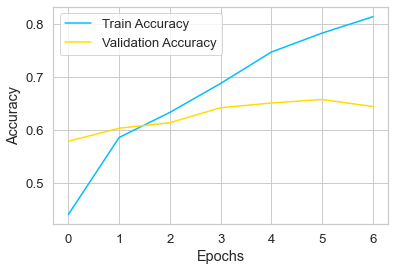

The CNN classification confusion matrix


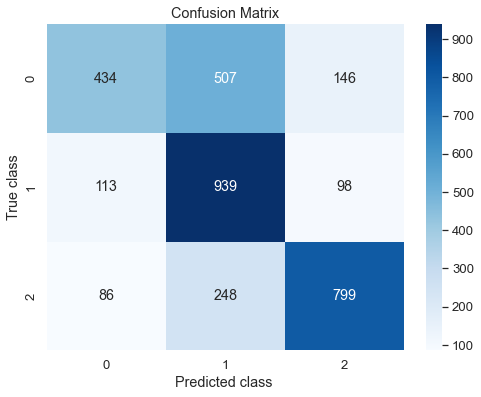

In [81]:


from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.metrics import classification_report


EMBEDDING_DIM = 100  # Adjust this dimension based on your Word2Vec or GloVe model


# Load and preprocess your data (replace 'df.tweet' and 'df.label' with your data)
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
tokenizer = Tokenizer(num_words=NB_WORDS, split=" ")
tokenizer.fit_on_texts(X_train)



X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)





# Define the CNN model
# Define the CNN model with a smaller filter size
cnn_model = Sequential()
cnn_model.add(Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
cnn_model.add(Conv1D(128, 3, activation='relu'))  # Reduced filter size to 3
cnn_model.add(MaxPooling1D(2))  # Reduced max-pooling size to 2
cnn_model.add(Conv1D(128, 3, activation='relu'))  # Reduced filter size to 3
cnn_model.add(MaxPooling1D(2))  # Reduced max-pooling size to 2
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(DROPOUT_RATE))
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = cnn_model.fit(X_train_seq, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Evaluate the model on test data
loss, accuracy = cnn_model.evaluate(X_test_seq, y_test, verbose=0)

# Evaluate the model on test data
loss, accuracy = cnn_model.evaluate(X_test_seq, y_test, verbose=0)

# Get predictions on the test data
y_pred = cnn_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

print('========================================================================================================\n')
# Calculate and print the classification report
print('The CNN classification metric')
report_CNN = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print("Classification Report for CNN Model:\n", report_CNN)

print('========================================================================================================\n')
# Print test loss and accuracy
print('The CNN test loss and accuracy values')
print('Test loss:', loss)
print('Test accuracy:', accuracy)

print('========================================================================================================\n')
# Plot training history (optional)
print('The CNN accuracy curve')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print('========================================================================================================')
# Calculate the confusion matrix
print('The CNN classification confusion matrix')
confusion_matrix1 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class ')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()


### LET TRAIN IT ON LSTM

2023-11-21 10:16:57.921647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:16:57.923781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:16:57.925381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-11-21 10:16:58.189079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:16:58.193080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:16:58.194804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

380/380 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.4181

2023-11-21 10:17:34.974968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:17:34.977037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:17:34.979573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

380/380 [==============================] - 38s 88ms/step - loss: 1.0871 - accuracy: 0.4181 - val_loss: 1.0351 - val_accuracy: 0.5712
Epoch 2/20
380/380 [==============================] - 33s 86ms/step - loss: 0.9195 - accuracy: 0.5737 - val_loss: 0.8270 - val_accuracy: 0.6343
Epoch 3/20
380/380 [==============================] - 34s 91ms/step - loss: 0.7912 - accuracy: 0.6357 - val_loss: 0.7860 - val_accuracy: 0.6558
Epoch 4/20
380/380 [==============================] - 34s 89ms/step - loss: 0.7200 - accuracy: 0.6732 - val_loss: 0.7587 - val_accuracy: 0.6714
Epoch 5/20
380/380 [==============================] - 35s 93ms/step - loss: 0.6483 - accuracy: 0.7197 - val_loss: 0.7444 - val_accuracy: 0.6780
Epoch 6/20
380/380 [==============================] - 34s 90ms/step - loss: 0.5738 - accuracy: 0.7597 - val_loss: 0.7335 - val_accuracy: 0.7077
Epoch 7/20
380/380 [==============================] - 33s 87ms/step - loss: 0.5082 - accuracy: 0.7994 - val_loss: 0.7489 - val_accuracy: 0.7188
Epo

2023-11-21 10:22:11.600773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:22:11.602752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:22:11.604527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

106/106 [==============================] - 4s 29ms/step
Test loss: 0.6996471881866455
Test accuracy: 0.7157270312309265
Classification Report for LSTM Model:
               precision    recall  f1-score   support

           0       0.69      0.62      0.65      1087
           1       0.66      0.71      0.68      1150
           2       0.81      0.81      0.81      1133

    accuracy                           0.72      3370
   macro avg       0.72      0.71      0.71      3370
weighted avg       0.72      0.72      0.72      3370



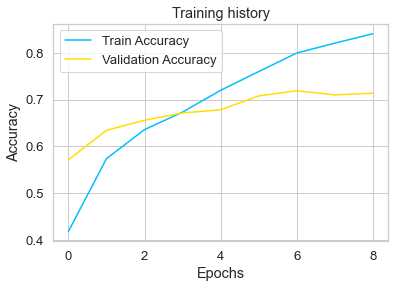

The LSTM+Embedding classification confusion matrix


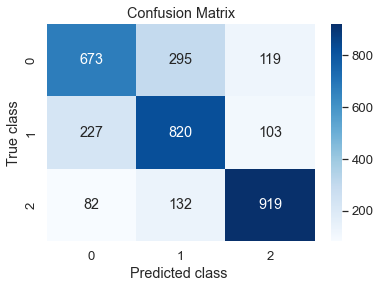

In [79]:

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping



EMBEDDING_DIM = 100  # Adjust this dimension based on your Word2Vec or GloVe model

# Load and preprocess your data (replace 'df.tweet' and 'df.label' with your data)
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
tokenizer = Tokenizer(num_words=NB_WORDS, split=" ")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# Define the LSTM model with reduced complexity and regularization
lstm_model = Sequential()
lstm_model.add(Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(DROPOUT_RATE))  # Increased dropout rate
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(DROPOUT_RATE))  # Increased dropout rate
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(DROPOUT_RATE))  # Increased dropout rate
lstm_model.add(Dense(3, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = lstm_model.fit(X_train_seq, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                        validation_split=0.1, callbacks=[early_stopping], verbose=1)



# Evaluate the model on test data
loss, accuracy = lstm_model.evaluate(X_test_seq, y_test, verbose=0)

print('========================================================================================================')
# Get predictions on the test data
y_pred = lstm_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

print('========================================================================================================')
# Print test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

print('========================================================================================================')
# Calculate and print the classification report
from sklearn.metrics import classification_report
report_LSTM = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print("Classification Report for LSTM Model:\n", report_LSTM)


print('========================================================================================================')
# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training history')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.ylim([0, 1])

print('========================================================================================================')
# Calculate the confusion matrix
print('The LSTM+Embedding classification confusion matrix')
confusion_matrix2 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
# Plot the confusion matrix as a heatmap

sns.heatmap(confusion_matrix2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class ')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()





## GRU MODEL

2023-11-21 10:29:09.970248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:29:09.972220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:29:09.974649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-11-21 10:29:10.246974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:29:10.249066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:29:10.250748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

380/380 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.4129

2023-11-21 10:29:46.835791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:29:46.837861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:29:46.839506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

380/380 [==============================] - 38s 87ms/step - loss: 1.0823 - accuracy: 0.4129 - val_loss: 1.0196 - val_accuracy: 0.5223
Epoch 2/20
380/380 [==============================] - 35s 93ms/step - loss: 0.8936 - accuracy: 0.5711 - val_loss: 0.8381 - val_accuracy: 0.5972
Epoch 3/20
380/380 [==============================] - 43s 112ms/step - loss: 0.7681 - accuracy: 0.6343 - val_loss: 0.7882 - val_accuracy: 0.6528
Epoch 4/20
380/380 [==============================] - 32s 85ms/step - loss: 0.6893 - accuracy: 0.6760 - val_loss: 0.7744 - val_accuracy: 0.6691
Epoch 5/20
380/380 [==============================] - 32s 85ms/step - loss: 0.6279 - accuracy: 0.7106 - val_loss: 0.7780 - val_accuracy: 0.6684
Epoch 6/20
380/380 [==============================] - 36s 94ms/step - loss: 0.5549 - accuracy: 0.7561 - val_loss: 0.7787 - val_accuracy: 0.6951
Epoch 7/20
380/380 [==============================] - 34s 90ms/step - loss: 0.4700 - accuracy: 0.8109 - val_loss: 0.7971 - val_accuracy: 0.7047


2023-11-21 10:33:22.413163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-21 10:33:22.415246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-21 10:33:22.416805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

106/106 [==============================] - 3s 18ms/step
Classification Report for GRU+embedding Model:
               precision    recall  f1-score   support

           0       0.62      0.43      0.50      1087
           1       0.58      0.71      0.64      1150
           2       0.77      0.83      0.80      1133

    accuracy                           0.66      3370
   macro avg       0.66      0.66      0.65      3370
weighted avg       0.66      0.66      0.65      3370

Test loss: 0.7473541498184204
Test accuracy: 0.6599406599998474


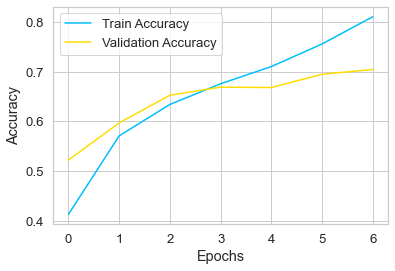

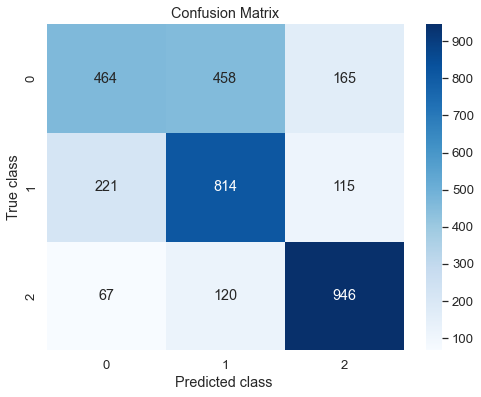

In [82]:

from keras.layers import Embedding, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.metrics import classification_report


EMBEDDING_DIM = 100  # Adjust this dimension based on your Word2Vec or GloVe model

# Load and preprocess your data (replace 'df.tweet' and 'df.label' with your data)
X_train, X_test, y_train, y_test = train_test_split(df.cleaned_tweet, df.label, test_size=0.2, random_state=101)
tokenizer = Tokenizer(num_words=NB_WORDS, split=" ")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the GRU model
gru_model = Sequential()
gru_model.add(Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(DROPOUT_RATE))  # Increased dropout rate
gru_model.add(GRU(64))
gru_model.add(Dropout(DROPOUT_RATE))  # Increased dropout rate
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(DROPOUT_RATE))  # Decreased dropout rate
gru_model.add(Dense(3, activation='softmax'))

# Compile the model
gru_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])



# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = gru_model.fit(X_train_seq, y_train, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE,
                       validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Evaluate the model on test data
loss, accuracy = gru_model.evaluate(X_test_seq, y_test, verbose=0)


# Get predictions on the test data
y_pred = gru_model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels


print('========================================================================================================')
# Calculate and print the classification report

report_GRU = classification_report(np.argmax(y_test, axis=1), y_pred_classes)
print("Classification Report for GRU+embedding Model:\n", report_GRU)

print('========================================================================================================')
# Print test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

print('========================================================================================================')
# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate the confusion matrix
confusion_matrix3 = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

print('========================================================================================================')
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix3, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class ')
plt.ylabel('True class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model
#emb_model2.save('emb_model2.h5')

# Later, when you want to use the model for inference
from keras.models import load_model

# Load the saved model
loaded_model = load_model('emb_model2.h5')

# Example new data (you need to preprocess and tokenize your new data accordingly)
new_data = ["@user Sosai makowa man u bata tsoro karawa da kowa, man united we stand 💪💪💪💪"]
# Tokenize and preprocess the new data (adjust this part as needed)
new_data_seq = tk.texts_to_sequences(new_data)
new_data_seq_trunc = pad_sequences(new_data_seq, maxlen=MAX_LEN, padding='post')

# Perform inference on the new data
predictions = loaded_model.predict(new_data_seq_trunc)

# Define the class mapping
class_mapping = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

# Map numerical predictions to labels
predicted_labels = [class_mapping[prediction.argmax()] for prediction in predictions]

# `predicted_labels` will contain the human-readable sentiment classifications for each input text
predicted_labels = [class_mapping[prediction.argmax()] for prediction in predictions]

# Print the predicted label for the example data
print("Predicted Label:", predicted_labels[0])